In [1]:
#add wget to kernel, but this is the import wget NOT USED
#import sys
#!{sys.executable} -m pip install wget

In [2]:
#to be run using
#
#mamba activate uhi_ch_less1  #From WSL
#
#jupyter notebook --port=8889 --no-browser  
#
# should be alrteady present thuis kernel
#python -m ipykernel install --user --name uhi_ch_less1 --display-name \ "Py UHI"
#
#

In [1]:
pwd

'/home/beber/fbk_sandbox/swiss_uhi/tn_uhi/notebooks'

In [2]:
!make -C .. regression_df

make: Entering directory '/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'
make: Nothing to be done for 'regression_df'.
make: Leaving directory '/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'


In [3]:
!mamba env list

# conda environments:
#
base                     /home/beber/mambaforge
colmap_slam              /home/beber/mambaforge/envs/colmap_slam
esa_snap                 /home/beber/mambaforge/envs/esa_snap
iot_luca                 /home/beber/mambaforge/envs/iot_luca
uhi                   *  /home/beber/mambaforge/envs/uhi
                         /home/beber/miniconda3
                         /home/beber/miniconda3/envs/qgis3.28
                         /home/beber/miniconda3/envs/uhi_ch1



In [4]:
! mkdir -p ../reports/figures

In [5]:
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm)
from sklearn import utils as sk_utils

from lausanne_heat_islands import utils

abba


In [6]:
regression_df_filepath = '../data/interim/regression/regression-df.csv'

In [7]:
regression_df = pd.read_csv(regression_df_filepath, index_col=[0, 1])

In [8]:
def make_dataset(regression_df,
                 features=None,
                 target='tair_station',
                 shuffle=True):
    y = regression_df[target]
    if features is None:
        X = regression_df.drop(target, axis=1)
    else:
        X = regression_df[list(features)]

    if shuffle:
        X, y = sk_utils.shuffle(X, y)

    return X, y

In [9]:
regression_df.head()

LST_0    NDWI_0    LST_200  NDWI_200    LST_400  \
date                                                                    
2022-06-25 T0101  30.195801 -0.312713  28.089384 -0.628542  27.522465   
           T0129  33.352997 -0.498808  33.617736 -0.578041  33.652676   
           T0135  31.509033 -0.609927  32.007493 -0.618595  33.138904   
           T0146  34.169647 -0.353147  31.945045 -0.657080  31.391921   
           T0408  29.294861 -0.575866  29.320462 -0.622653  29.160690   

                  NDWI_400    LST_600  NDWI_600    LST_800  NDWI_800  elev  \
date                                                                         
2022-06-25 T0101 -0.680043  27.466189 -0.661900  27.384293 -0.670186   205   
           T0129 -0.549902  33.217063 -0.564309  33.347419 -0.550984   312   
           T0135 -0.525348  32.803438 -0.528557  32.741101 -0.494778   194   
           T0146 -0.702617  31.044979 -0.710097  30.817719 -0.716112   182   
           T0408 -0.641180  28.452137 -0.676135  28.540261 -0.669386   204   

                  tair_station  
date                            
2022-06-25 T0101     23.866667  
           T0129     22.800000  
           T0135     24.466667  
           T0146     24.933333  
           T0408     23.833333

After dropping the missing observations, the total number of samples is:

In [10]:
len(regression_df)

45

## Model performance

In [11]:
target = 'tair_station'

model_dict = {
    'lr': linear_model.LinearRegression,
    'svm': svm.SVR,    
    'rf': ensemble.RandomForestRegressor
}

In [14]:
#need to add localy since not in the last release
# STATS
#METRIC_COLUMNS = ['R^2', 'MAE', 'RMSE']

#def compute_model_perf(obs, pred):
#    return [
#        metrics.r2_score(obs, pred),
#        metrics.mean_absolute_error(obs, pred),
#        metrics.mean_squared_error(obs, pred, squared=False)]

# let's add them to utils
#USUALLY DON'T DO THIS is a BAD idea
#import types

#M0 abshttps://stackoverflow.com/questions/972/adding-a-method-to-an-existing-object-instance
#utils.compute_model_perf = compute_model_perf.__get__(utils)
#M1
#foo.sample_method = types.MethodType(sample_method, foo)
#utils.compute_model_perf = types.MethodType(compute_model_perf, utils)





In [12]:
X, y = make_dataset(regression_df, target=target)

model_perf_df = pd.DataFrame(columns=['R^2', 'MAE', 'RMSE'])
for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)
    y_pred = regr.predict(X)
    model_perf_df.loc[model.__name__] = [metrics.r2_score(y, y_pred),
                                        metrics.mean_absolute_error(y, y_pred),
                                        metrics.mean_squared_error(y, y_pred, squared=False)]


model_perf_df.style.set_caption('Table 1. Model performance with all samples')

,R^2,MAE,RMSE
LinearRegression,0.580682,1.199755,1.428576
SVR,-0.023687,1.736868,2.232109
RandomForestRegressor,0.836058,0.770000,0.893258


If all the samples are considered, the random forest regressor achieves the best fit with a coefficient of determination of $R^2 = 0.960$, followed by the $R^2 = 0.832$ achieved by the ordinary linear regression.

### Cross validation

In [13]:
num_repetitions = 10
num_folds = 3

In [14]:
accuracy_df = pd.DataFrame(columns=model_dict.keys(),
                           index=range(num_repetitions))

for i in range(num_repetitions):
    X, y = make_dataset(regression_df, target=target)

    for model_label in model_dict:
        accuracy_df.loc[(i, model_label)] = model_selection.cross_val_score(
            model_dict[model_label](), X, y, cv=num_folds).mean()

# output a Table with nicer row/column labels
pd.DataFrame({
    'Cross validation R^2': accuracy_df.mean()
}).rename(index=lambda model_label: model_dict[model_label].__name__
          ).style.set_caption('Table 2. Cross validation scores')

,Cross validation R^2
LinearRegression,-0.334500
SVR,-0.343692
RandomForestRegressor,-0.921989


The cross validation suggests that the linear regression is more robust to missing data and also less likely to over-fit the observations than the random forest regressor.

## Feature importance

In [15]:
X, y = make_dataset(regression_df, target=target)

for model_label in model_dict:
    model = model_dict[model_label]
    regr = model().fit(X, y)

    importance_df = pd.DataFrame(
        inspection.permutation_importance(regr, X, y),
        index=regression_df.drop(target, axis=1).columns,
        columns=[f'importances_{param}' for param in ('mean', 'std')])
    print(model)
    print(
        importance_df.sort_values(by='importances_mean',
                                  ascending=False).head(10))
    print()

<class 'sklearn.linear_model._base.LinearRegression'>
          importances_mean  importances_std
LST_600         729.049085       106.849244
LST_400         473.426547        80.094478
LST_800         198.722777        26.283922
LST_200         102.342677        20.880170
NDWI_400         99.918015        16.314589
NDWI_600         61.228166        10.408344
NDWI_200         14.313562         3.398755
LST_0             5.681475         1.238136
NDWI_800          5.191933         0.725096
elev              0.231103         0.083602

<class 'sklearn.svm._classes.SVR'>
          importances_mean  importances_std
LST_800       2.834381e-04     1.269102e-04
LST_600       1.411502e-04     7.796946e-05
LST_400       5.694413e-05     4.127574e-05
LST_200       3.948592e-06     1.981532e-05
NDWI_200      4.187939e-07     1.941943e-07
NDWI_0        2.280566e-07     7.057842e-08
NDWI_400      1.144192e-07     1.849981e-07
NDWI_600      3.328813e-08     1.356440e-07
NDWI_800      1.152132e-08    

The feature importances change dramatically according to the regression model.

In the case of linear regression, the feature importances can be futher assessed by a F-test of significance:

In [16]:
est = sm.OLS(y, sm.add_constant(X))
est.fit().summary(title='Table 3. OLS regression results')

<class 'statsmodels.iolib.summary.Summary'>
"""
                       Table 3. OLS regression results                        
==============================================================================
Dep. Variable:           tair_station   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     4.154
Date:                Fri, 09 Jun 2023   Prob (F-statistic):           0.000709
Time:                        14:19:49   Log-Likelihood:                -79.903
No. Observations:                  45   AIC:                             183.8
Df Residuals:                      33   BIC:                             205.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -21.4162      9.760     -2.194      0.035     -41.274      -1.559
LST_0          1.0855      0.977      1.111      0.275      -0.903       3.074
NDWI_0         2.0398      5.824      0.350      0.728      -9.810      13.889
LST_200       -4.9356      2.405     -2.052      0.048      -9.829      -0.042
NDWI_200      45.4762     29.064      1.565      0.127     -13.655     104.607
LST_400       11.7395      4.012      2.926      0.006       3.578      19.901
NDWI_400    -132.9741     49.200     -2.703      0.011    -233.071     -32.877
LST_600      -14.7119      3.801     -3.871      0.000     -22.445      -6.979
NDWI_600     111.6475     36.323      3.074      0.004      37.748     185.547
LST_800        8.2070      1.771      4.635      0.000       4.605      11.809
NDWI_800     -33.9987     17.695     -1.921      0.063     -70.000       2.002
elev          -0.0215      0.012     -1.730      0.093      -0.047       0.004
==============================================================================
Omnibus:                        5.009   Durbin-Watson:                   1.224
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.890
Skew:                           0.596   Prob(JB):                        0.143
Kurtosis:                       2.191   Cond. No.                     5.73e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.73e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

With a significance level of $p=0.05$, the results of the F-test suggest that the significant variables for the linear regression are the NDWI when spatially averaged over a 800m, 600m and 400m radius (in decreasing order of significance). The following most significant variable is the NDWI spatially averaged over a 200m radius ($p=0.071$) and without spatial averaging ($p=0.231$), and the LST spatially averaged over a 400m radius ($p=0.277$). With a $p=0.420$, the does not appear to be significant in this particular regression.

## Prediction with the chosen model

In [17]:
X, y = make_dataset(regression_df, shuffle=False)

regr = ensemble.RandomForestRegressor().fit(X, y)
#regr = linear_model.LinearRegression().fit(X, y)

y_pred = regr.predict(X)

# for TN case the random forest perform better

## Unraveling the error patterns

In [18]:
comparison_df = regression_df.copy()

comparison_df['obs'] = y
comparison_df['pred'] = y_pred
comparison_df['err'] = y_pred - y
#comparison_df['sq_err'] = comparison_df['err']**2

comparison_df['date'] = pd.to_datetime(comparison_df.index.get_level_values(0))
comparison_df['station'] = comparison_df.index.get_level_values(1)

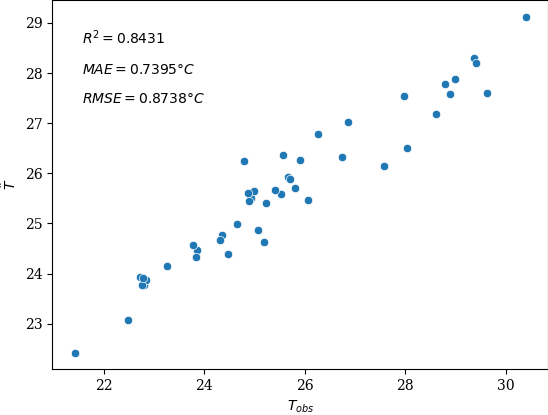

In [19]:
fig = utils.plot_pred_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-pred-obs.pdf')

In [20]:
print(comparison_df.err.min(), comparison_df.err.max())

-2.044928571428578 1.4424175824176046


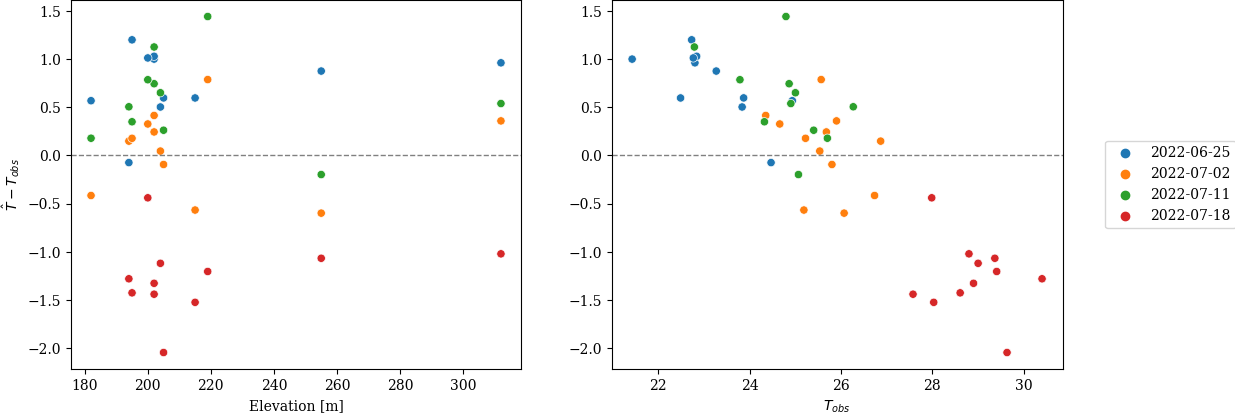

In [21]:
fig = utils.plot_err_elev_obs(comparison_df)
fig.savefig('../reports/figures/spatial-regression-errors.pdf')

### Plotting the maps predicted by the spatial regression

In [22]:
import pandas as pd
import statsmodels.api as sm
import xarray as xr
from sklearn import (ensemble, inspection, linear_model, metrics,
                     model_selection, svm)
from sklearn import utils as sk_utils

from lausanne_heat_islands import utils

In [23]:
!pwd

/home/beber/fbk_sandbox/swiss_uhi/tn_uhi/notebooks


In [24]:
# need to fix the dem before running this, now is working

In [25]:
!make -C .. tair_regr_maps

make: Entering directory '/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'
make: Nothing to be done for 'tair_regr_maps'.
make: Leaving directory '/home/beber/fbk_sandbox/swiss_uhi/tn_uhi'


In [26]:
tair_regr_filepath = '../data/processed/tair-regr-maps.nc'
station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [27]:

T_regr_da = xr.open_dataarray(tair_regr_filepath)
station_location_df = pd.read_csv(station_locations_filepath, index_col='stn')

In [28]:
T_regr_da

<xarray.DataArray 'T' (time: 4, y: 178, x: 53)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
  * y        (y) float64 5.122e+06 5.122e+06 5.122e+06 ... 5.087e+06 5.087e+06
  * x        (x) float64 6.593e+05 6.595e+05 6.597e+05 ... 6.695e+05 6.697e+05
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [29]:
pwd

'/home/beber/fbk_sandbox/swiss_uhi/tn_uhi/notebooks'

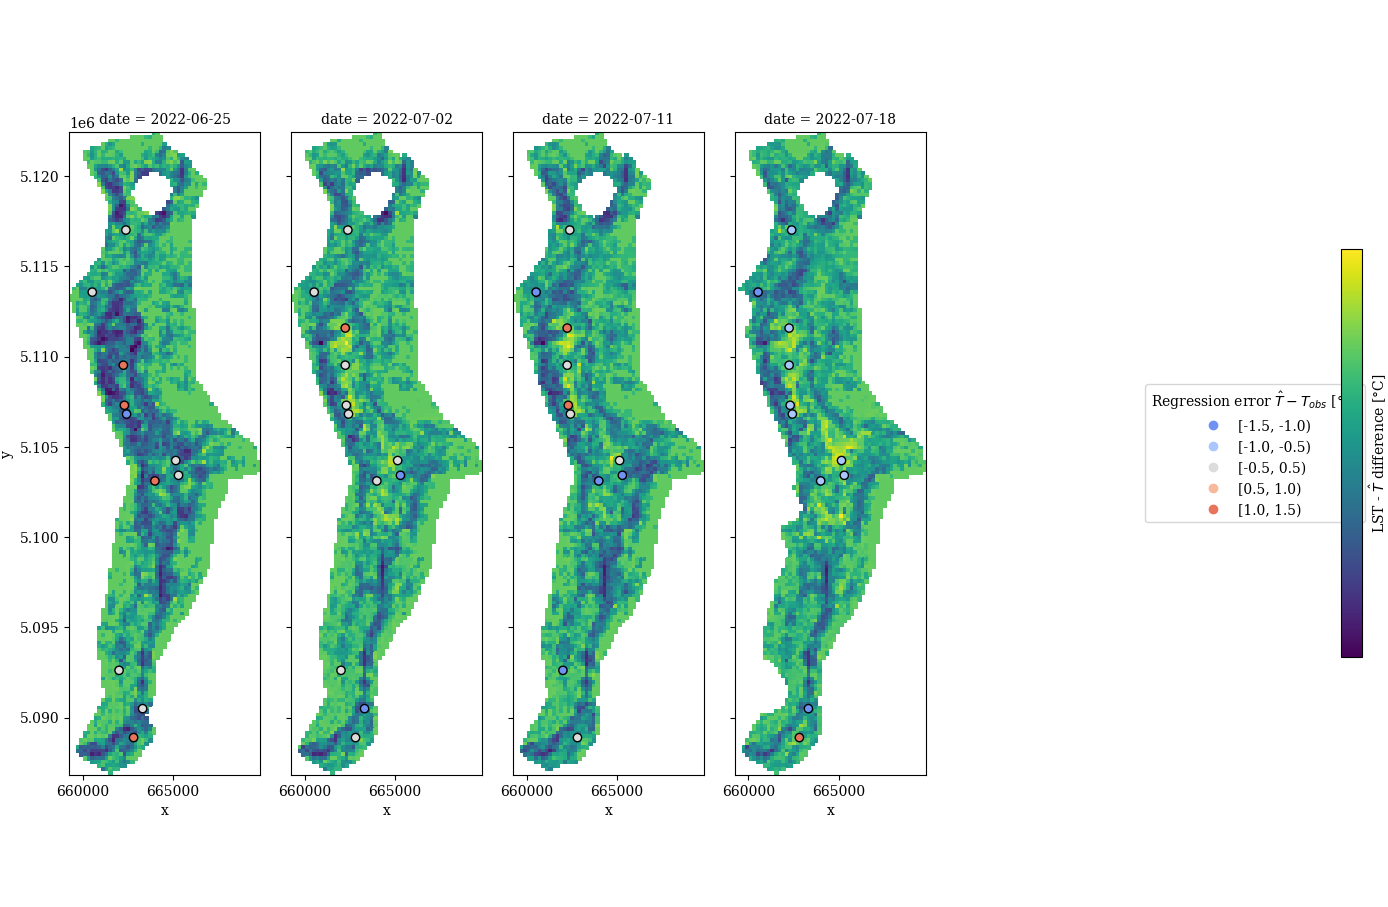

In [30]:
from lausanne_heat_islands import utils
g = utils.plot_T_maps(T_regr_da,
                      station_location_df,
                      comparison_df=comparison_df)
g.fig.savefig('../reports/figures/spatial-regression-maps.png')
g

In [31]:
import salem

In [32]:
tlst_filepath = '../data/interim/regression/landsat-features.nc'
#station_locations_filepath = '../data/raw/stations/station-locations.csv'

In [33]:

landsat_features_ds = xr.open_dataset(tlst_filepath)


In [34]:
# note that we need to forward the dataset attributes to its data variables
for data_var in landsat_features_ds.data_vars:
        landsat_features_ds[data_var].attrs = landsat_features_ds.attrs.copy()
    # align it

In [35]:
landsat_features_ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
Data variables:
    NDVI     (time, y, x) float32 ...
    NDWI     (time, y, x) float32 ...
    LST      (time, y, x) float32 ...
Attributes:
    pyproj_srs:  epsg:32632

In [36]:
import geopandas as gpd
agglom_extent_gdf = gpd.read_file('../data/raw/agglom-extent/agglom-extent.shp')
#just to be sure reproject agglom_extent_gdf from 4326 to 32632
#rb added
agglom_extent_gdf = agglom_extent_gdf.to_crs('EPSG:32632')
crs = agglom_extent_gdf.crs
data_geom = agglom_extent_gdf.loc[0]['geometry']
# add a buffer to compute the convolution features well
ref_geom = data_geom.buffer(2000)
# use the ref geometry to obtain the reference grid (data array) with the
# target resolution
dst_res = 30
ref_da = utils.get_ref_da(ref_geom, dst_res, dst_fill=0, dst_crs=crs)


/home/beber/mambaforge/envs/uhi/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [37]:
# align it
landsat_features_ds = ref_da.salem.transform(landsat_features_ds,interp='linear')

In [38]:
landsat_features_ds

<xarray.Dataset>
Dimensions:  (time: 4, x: 487, y: 1319)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
  * x        (x) float64 6.573e+05 6.573e+05 6.573e+05 ... 6.718e+05 6.718e+05
  * y        (y) float64 5.124e+06 5.124e+06 5.124e+06 ... 5.085e+06 5.085e+06
Data variables:
    NDVI     (time, y, x) float32 0.81505257 0.7780632 0.7378249 ... nan nan nan
    NDWI     (time, y, x) float32 -0.7570719 -0.7285914 -0.6907416 ... nan nan
    LST      (time, y, x) float32 27.33269 27.695477 28.062641 ... nan nan nan
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [39]:
landsat_features_ds_trim = T_regr_da.salem.transform(landsat_features_ds,interp='linear')

In [40]:
landsat_features_ds_trim

<xarray.Dataset>
Dimensions:  (time: 4, x: 53, y: 178)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
  * x        (x) float64 6.593e+05 6.595e+05 6.597e+05 ... 6.695e+05 6.697e+05
  * y        (y) float64 5.122e+06 5.122e+06 5.122e+06 ... 5.087e+06 5.087e+06
Data variables:
    NDVI     (time, y, x) float32 0.8413979 0.87415135 ... 0.7166698 0.82091415
    NDWI     (time, y, x) float32 -0.77145207 -0.7989796 ... -0.75669134
    LST      (time, y, x) float32 26.495605 25.98768 ... 29.805645 29.400074
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

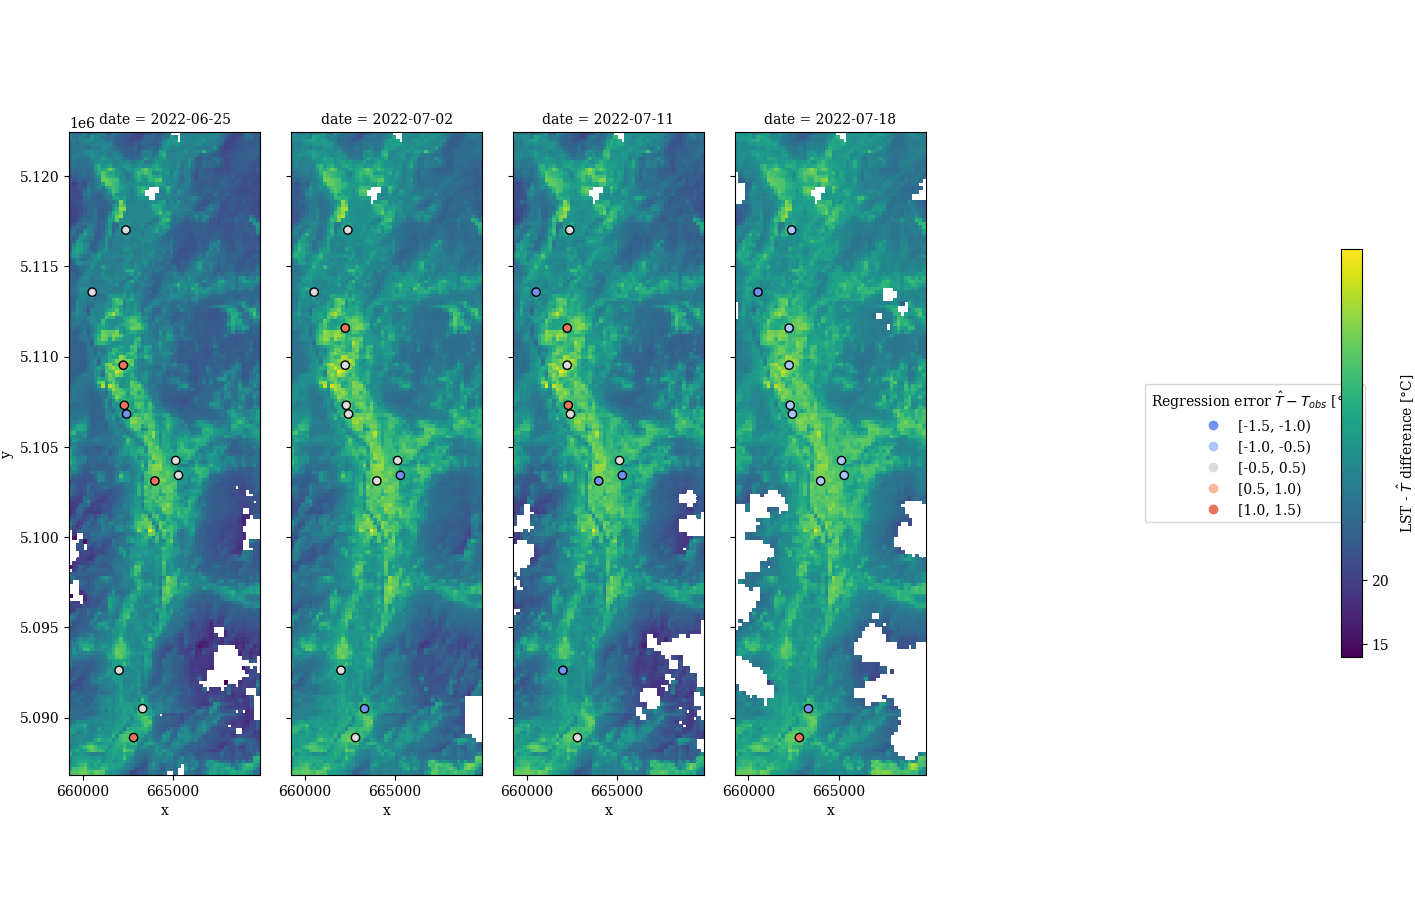

In [41]:
g = utils.plot_T_maps(landsat_features_ds_trim['LST'],
                      station_location_df,
                      comparison_df=comparison_df)
g.fig.savefig('../reports/figures/lst-maps.png')


In [42]:
print((landsat_features_ds_trim['LST'] - T_regr_da).min(),
(landsat_features_ds_trim['LST'] - T_regr_da).max())

<xarray.DataArray ()>
array(-6.67510806) <xarray.DataArray ()>
array(20.41673279)


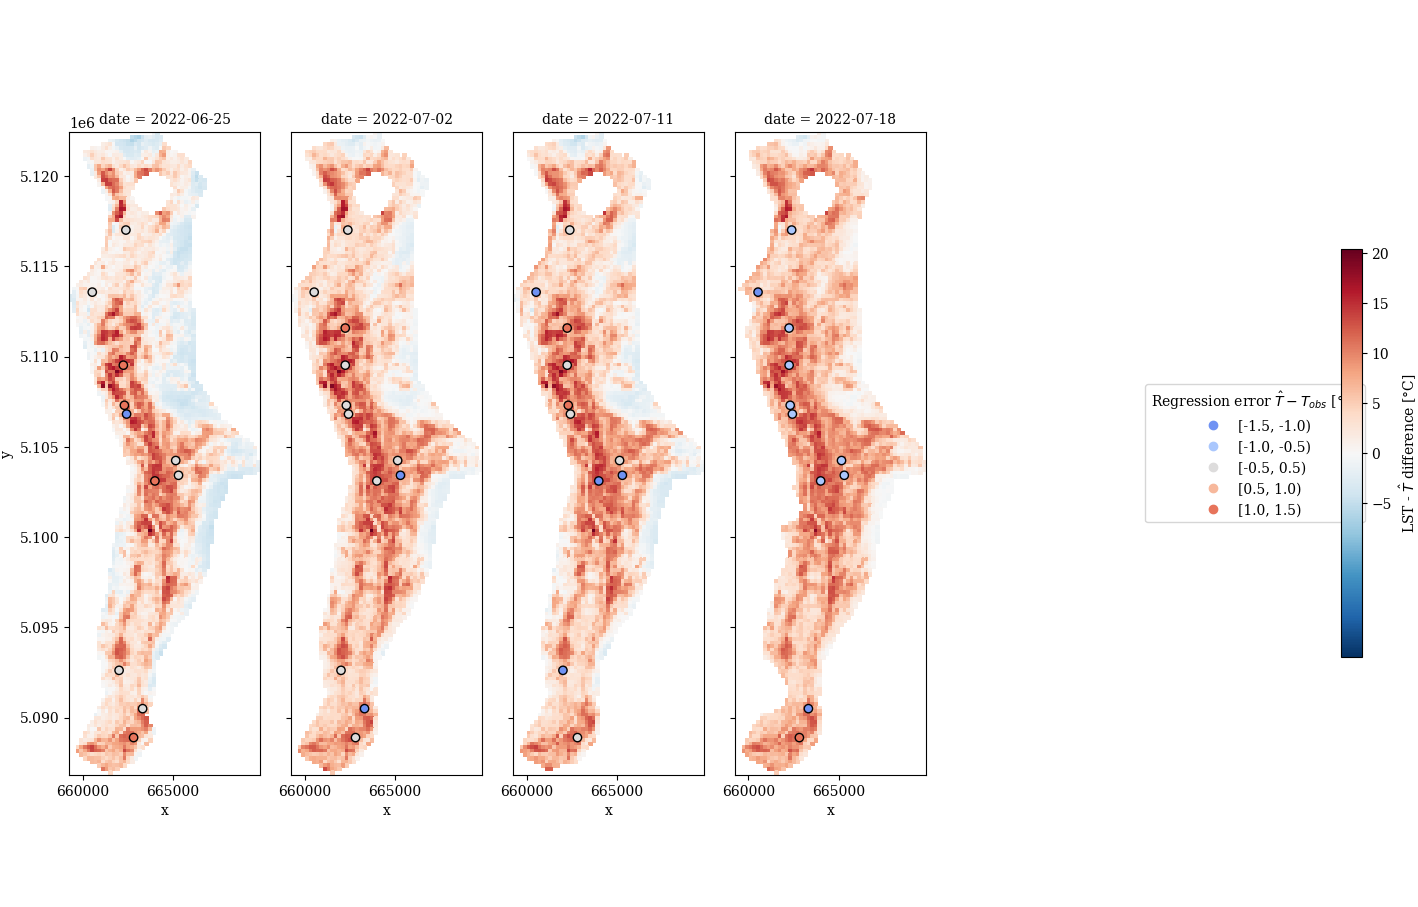

In [43]:
g = utils.plot_T_maps(landsat_features_ds_trim['LST'] - T_regr_da,
                      station_location_df,
                      comparison_df=comparison_df)
g
g.fig.savefig('../reports/figures/air_lst_diff-maps.png')

#landsat_features_ds_trim['LST'] - T_regr_da

In [44]:
diff = landsat_features_ds_trim['LST'] - T_regr_da

In [45]:
import numpy as np

print(np.unique(diff))

[-6.67510806 -6.22456561 -6.12244998 ...         nan         nan
         nan]


In [46]:
min(np.unique(diff))

-6.675108062017536

In [47]:
help(utils)

Help on module lausanne_heat_islands.utils in lausanne_heat_islands:

NAME
    lausanne_heat_islands.utils

FUNCTIONS
    colorbar(mappable)
    
    get_ref_da(ref_geom, dst_res, dst_fill=0, dst_crs=None)
    
    plot_T_maps(T_da, station_location_df, num_cols=6, comparison_df=None, err_classes=None, **plot_kws)
    
    plot_comparison_hists(T_diff_da, station_tair_df)
    
    plot_err_elev_obs(comparison_df)
    
    plot_pred_obs(comparison_df)

DATA
    CRS = 'epsg:32632'
    ERR_BOUNDARIES = [-12, -6, -2, 2, 6, 12]
    ERR_CLASSES = [-1.5, -1.0, -0.5, 0.5, 1.0, 1.5]

FILE
    /home/beber/fbk_sandbox/swiss_uhi/tn_uhi/lausanne_heat_islands/utils.py




In [48]:
dir(utils)

['CRS',
 'ERR_BOUNDARIES',
 'ERR_CLASSES',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_calculate_transform',
 'colorbar',
 'colors',
 'geometry',
 'get_ref_da',
 'gpd',
 'metrics',
 'mpl',
 'np',
 'pd',
 'plot_T_maps',
 'plot_comparison_hists',
 'plot_err_elev_obs',
 'plot_pred_obs',
 'plt',
 'sns',
 'transform',
 'xr']

## check integrity of T_regr_da

In [52]:
#first try run on default data
airtemps = xr.tutorial.open_dataset("air_temperature")
air = airtemps.air - 273.15
air.attrs = airtemps.air.attrs
air.attrs["units"] = "deg C"

In [53]:
air

<xarray.DataArray 'air' (time: 2920, lat: 25, lon: 53)>
array([[[-31.949997, -30.649994, -29.649994, ..., -40.350006,
         -37.649994, -34.550003],
        [-29.350006, -28.649994, -28.449997, ..., -40.350006,
         -37.850006, -33.850006],
        [-23.149994, -23.350006, -24.259995, ..., -39.949997,
         -36.759995, -31.449997],
        ...,
        [ 23.450012,  23.049988,  23.25    , ...,  22.25    ,
          21.950012,  21.549988],
        [ 22.75    ,  23.049988,  23.640015, ...,  22.75    ,
          22.75    ,  22.049988],
        [ 23.140015,  23.640015,  23.950012, ...,  23.75    ,
          23.640015,  23.450012]],

       [[-31.050003, -30.449997, -30.050003, ..., -41.149994,
         -39.550003, -37.350006],
        [-29.550003, -29.050003, -28.949997, ..., -42.149994,
         -40.649994, -37.449997],
        [-19.949997, -20.259995, -21.050003, ..., -42.350006,
         -39.759995, -34.649994],
        ...,
        [ 23.25    ,  22.75    ,  23.049988, ...,  22.25    ,
          21.950012,  21.640015],
        [ 23.049988,  23.549988,  23.640015, ...,  22.450012,
          22.350006,  21.950012],
        [ 23.140015,  24.049988,  24.25    , ...,  23.25    ,
          23.25    ,  23.450012]],

       [[-30.850006, -30.949997, -30.850006, ..., -38.850006,
         -37.050003, -34.449997],
        [-28.550003, -28.759995, -29.149994, ..., -42.850006,
         -41.149994, -37.449997],
        [-16.950012, -17.649994, -18.949997, ..., -41.949997,
         -39.949997, -34.949997],
        ...,
        [ 22.450012,  22.25    ,  22.25    , ...,  23.140015,
          22.140015,  21.850006],
        [ 23.049988,  23.350006,  23.140015, ...,  23.25    ,
          22.850006,  22.450012],
        [ 23.25    ,  23.140015,  23.25    , ...,  23.850006,
          23.850006,  23.640015]],

       ...,

       [[-29.660004, -30.160004, -31.059998, ..., -28.960007,
         -28.660004, -28.259995],
        [-24.059998, -24.160004, -24.559998, ..., -32.559998,
         -31.86    , -30.460007],
        [-10.459991, -10.959991, -11.459991, ..., -33.759995,
         -31.460007, -27.960007],
        ...,
        [ 21.640015,  22.140015,  24.339996, ...,  22.339996,
          22.23999 ,  21.540009],
        [ 23.640015,  24.73999 ,  25.140015, ...,  22.339996,
          22.339996,  21.640015],
        [ 25.040009,  26.040009,  25.640015, ...,  22.940002,
          22.640015,  22.640015]],

       [[-27.36    , -28.36    , -29.660004, ..., -29.86    ,
         -29.160004, -28.36    ],
        [-23.259995, -23.86    , -24.660004, ..., -31.86    ,
         -30.660004, -28.86    ],
        [-10.76001 , -11.359985, -11.859985, ..., -32.660004,
         -30.059998, -26.259995],
        ...,
        [ 20.540009,  20.73999 ,  22.23999 , ...,  21.940002,
          21.540009,  21.140015],
        [ 23.140015,  24.040009,  24.440002, ...,  22.140015,
          21.940002,  21.23999 ],
        [ 24.640015,  25.23999 ,  25.339996, ...,  22.540009,
          22.339996,  22.040009]],

       [[-28.059998, -28.86    , -29.86    , ..., -31.460007,
         -31.660004, -31.36    ],
        [-23.259995, -23.86    , -24.759995, ..., -33.559998,
         -32.86    , -31.460007],
        [-10.160004, -10.959991, -11.76001 , ..., -33.259995,
         -30.559998, -26.86    ],
        ...,
        [ 20.640015,  20.540009,  21.940002, ...,  22.140015,
          21.940002,  21.540009],
        [ 22.940002,  23.73999 ,  24.040009, ...,  22.540009,
          22.540009,  22.040009],
        [ 24.540009,  24.940002,  24.940002, ...,  23.339996,
          23.040009,  22.540009]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Attributes:
    long_name:     4xDaily Air temperature at sigma level 995
    units:         deg C
    precision:     2
    GRI

In [54]:
t = air.isel(time=slice(0, 365 * 4, 250))

In [55]:
t

<xarray.DataArray 'air' (time: 6, lat: 25, lon: 53)>
array([[[-31.949997  , -30.649994  , -29.649994  , ..., -40.350006  ,
         -37.649994  , -34.550003  ],
        [-29.350006  , -28.649994  , -28.449997  , ..., -40.350006  ,
         -37.850006  , -33.850006  ],
        [-23.149994  , -23.350006  , -24.259995  , ..., -39.949997  ,
         -36.759995  , -31.449997  ],
        ...,
        [ 23.450012  ,  23.049988  ,  23.25      , ...,  22.25      ,
          21.950012  ,  21.549988  ],
        [ 22.75      ,  23.049988  ,  23.640015  , ...,  22.75      ,
          22.75      ,  22.049988  ],
        [ 23.140015  ,  23.640015  ,  23.950012  , ...,  23.75      ,
          23.640015  ,  23.450012  ]],

       [[-31.350006  , -32.449997  , -33.649994  , ..., -42.149994  ,
         -39.759995  , -37.259995  ],
        [-27.550003  , -29.149994  , -30.759995  , ..., -42.649994  ,
         -40.449997  , -37.649994  ],
        [-16.850006  , -18.649994  , -20.649994  , ..., -45.649994  ,
         -42.550003  , -37.649994  ],
        ...,
        [ 21.850006  ,  20.950012  ,  20.450012  , ...,  23.049988  ,
          22.75      ,  22.140015  ],
        [ 22.549988  ,  22.350006  ,  21.850006  , ...,  22.549988  ,
          22.049988  ,  21.75      ],
        [ 22.950012  ,  22.950012  ,  23.049988  , ...,  22.450012  ,
          22.049988  ,  22.049988  ]],

       [[-12.75      , -13.049988  , -12.950012  , ..., -22.850006  ,
         -22.350006  , -21.449997  ],
        [-12.25      , -12.859985  , -13.149994  , ..., -24.949997  ,
         -23.850006  , -21.759995  ],
        [ -8.549988  ,  -9.75      , -10.859985  , ..., -24.350006  ,
         -21.949997  , -18.449997  ],
        ...,
        [ 24.450012  ,  24.350006  ,  24.25      , ...,  23.450012  ,
          23.25      ,  22.450012  ],
        [ 25.049988  ,  25.350006  ,  25.25      , ...,  23.75      ,
          23.549988  ,  22.950012  ],
        [ 25.140015  ,  25.549988  ,  25.450012  , ...,  24.25      ,
          24.25      ,  24.140015  ]],

       [[  2.850006  ,   2.350006  ,   1.9500122 , ...,  -4.950012  ,
          -3.3599854 ,  -1.6499939 ],
        [  3.350006  ,   3.25      ,   3.0499878 , ...,  -5.3599854 ,
          -2.75      ,   0.14001465],
        [  6.850006  ,   7.049988  ,   7.049988  , ...,  -4.549988  ,
          -1.75      ,   1.1400146 ],
        ...,
        [ 24.75      ,  23.75      ,  23.25      , ...,  25.140015  ,
          24.25      ,  23.640015  ],
        [ 25.049988  ,  24.549988  ,  24.049988  , ...,  24.950012  ,
          24.640015  ,  24.450012  ],
        [ 25.850006  ,  25.549988  ,  25.049988  , ...,  25.350006  ,
          25.350006  ,  25.25      ]],

       [[ -1.6499939 ,  -1.75      ,  -1.8599854 , ..., -17.949997  ,
         -16.649994  , -14.450012  ],
        [  2.25      ,   1.8500061 ,   1.25      , ..., -19.050003  ,
         -16.450012  , -12.450012  ],
        [  4.6400146 ,   4.549988  ,   4.25      , ..., -12.549988  ,
          -9.359985  ,  -5.149994  ],
        ...,
        [ 25.640015  ,  25.549988  ,  25.549988  , ...,  26.049988  ,
          25.75      ,  25.450012  ],
        [ 26.350006  ,  26.140015  ,  25.850006  , ...,  26.75      ,
          26.549988  ,  26.350006  ],
        [ 26.450012  ,  26.350006  ,  26.049988  , ...,  26.640015  ,
          27.049988  ,  27.25      ]],

       [[-12.859985  , -14.359985  , -16.049988  , ..., -32.649994  ,
         -30.550003  , -28.350006  ],
        [ -4.049988  ,  -4.950012  ,  -6.75      , ..., -37.149994  ,
         -35.449997  , -32.350006  ],
        [ -2.25      ,  -3.3599854 ,  -4.649994  , ..., -41.649994  ,
         -38.649994  , -32.949997  ],
        ...,
        [ 24.350006  ,  23.450012  ,  23.350006  , ...,  25.850006  ,
          24.850006  ,  24.549988  ],
        [ 25.049988  ,  24.640015  ,  24.25      , ...,  26.049988  ,
          25.850006  ,  25.549988  ],
        [ 25.140015  ,  24.950012  ,  24.950012  , ...,  26.549988  ,
         

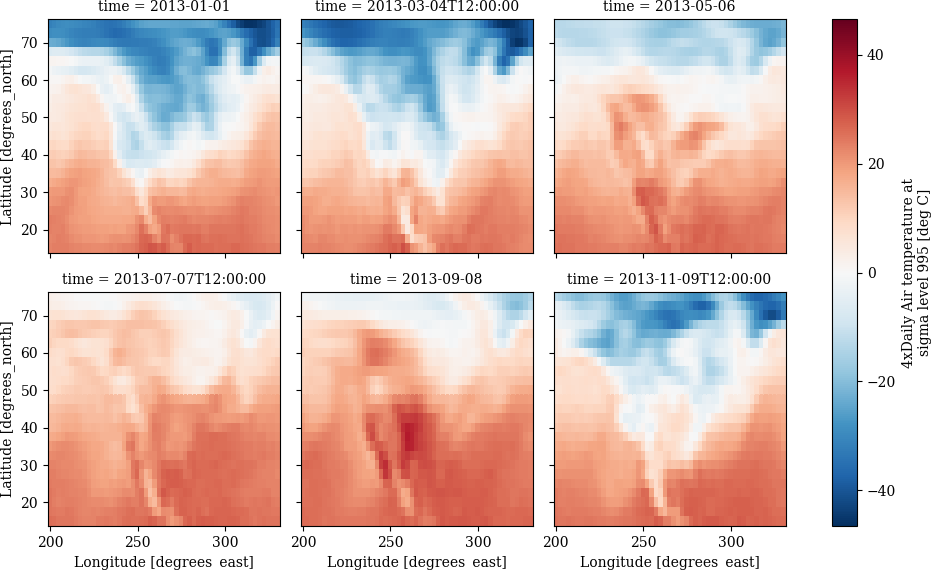

In [56]:
g_simple = t.plot(x="lon", y="lat", col="time", col_wrap=3)

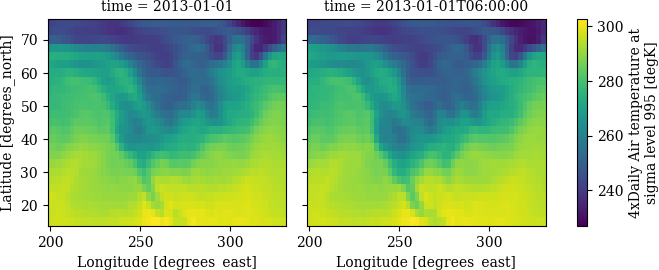

In [57]:
#demo to reproduce error
import xarray as xr
airtemps = xr.tutorial.open_dataset("air_temperature") 
airtemps['air'].isel(time=slice(2)).plot(col='time') 

#check pandas version
#https://github.com/pydata/xarray/issues/4319

In [58]:
#check pandas version
!pip show pandas

Name: pandas
Version: 1.0.5
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: 
Author-email: 
License: BSD
Location: /home/beber/mambaforge/envs/uhi/lib/python3.7/site-packages
Requires: numpy, python-dateutil, pytz
Required-by: geopandas, natcap.invest, pylandsat, seaborn, statsmodels, xarray


In [59]:
T_regr_da.T.size

37736

In [60]:
T_regr_da.dims

('time', 'y', 'x')

In [61]:
T_regr_da

<xarray.DataArray 'T' (time: 4, y: 178, x: 53)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]],

       [[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 2022-06-25 2022-07-02 2022-07-11 2022-07-18
  * y        (y) float64 5.122e+06 5.122e+06 5.122e+06 ... 5.087e+06 5.087e+06
  * x        (x) float64 6.593e+05 6.595e+05 6.597e+05 ... 6.695e+05 6.697e+05
Attributes:
    pyproj_srs:  +proj=utm +zone=32 +datum=WGS84 +units=m +no_defs

In [62]:
import geopandas as gpd
from shapely import geometry
import numpy as np
import seaborn as sns
from matplotlib import colors
import matplotlib.pyplot as plt


['__add__',
 '__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getnewargs__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__mul__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__rmul__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'count',
 'index']

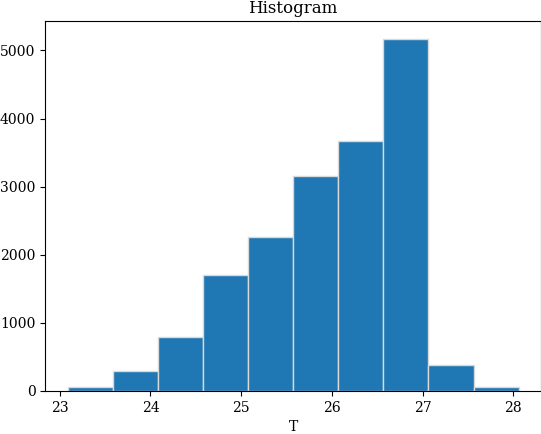

In [63]:
dir(T_regr_da.plot())

In [64]:
help(T_regr_da)

Help on DataArray in module xarray.core.dataarray object:

class DataArray(xarray.core.common.AbstractArray, xarray.core.common.DataWithCoords)
 |  DataArray(data: Any = <NA>, coords: Union[Sequence[Tuple], Mapping[Hashable, Any], NoneType] = None, dims: Union[Hashable, Sequence[Hashable], NoneType] = None, name: Hashable = None, attrs: Mapping = None, indexes: Dict[Hashable, pandas.core.indexes.base.Index] = None, fastpath: bool = False)
 |  
 |  N-dimensional array with labeled coordinates and dimensions.
 |  
 |  DataArray provides a wrapper around numpy ndarrays that uses labeled
 |  dimensions and coordinates to support metadata aware operations. The API is
 |  similar to that for the pandas Series or DataFrame, but DataArray objects
 |  can have any number of dimensions, and their contents have fixed data
 |  types.
 |  
 |  Additional features over raw numpy arrays:
 |  
 |  - Apply operations over dimensions by name: ``x.sum('time')``.
 |  - Select or assign values by integer l

In [65]:
***********************
TO .|.. DEBUG .|.. HERE
^^^^^^^^^^^^^^^^^^^^^^^

!!!!!SOLVED!!!!!
check out this https://github.com/pydata/xarray/pull/4292
in environmet.yml file downgraded pandas to be <1.1    
    

SyntaxError: invalid syntax (1048407522.py, line 1)

In [ ]:
g = T_regr_da.plot(
        x='x',
        y='y',
        col='time',
        col_wrap=3,
        cbar_kwargs={
             'shrink': .2,
             'pad': 0.02,
         },
        add_colorbar=False)

In [ ]:
g = T_regr_da.to_array().plot(col="time")

In [ ]:
T_regr_da.shape


In [ ]:
dir(T_regr_da)

In [ ]:
T_regr_da.coords

In [ ]:
g = T_regr_da.plot(x="x", y="y", col="time", col_wrap=3)

In [ ]:


    # post-processing
fig = g.fig
flat_axes = g.axes.flatten()

    # prepare last axis for the legend
last_ax = flat_axes[-1]
last_ax.set_visible(True)
last_ax.axis('off')

In [ ]:

err_gdf = gpd.GeoDataFrame(comparison_df['date'],
            geometry=list(comparison_df['station'].map(lambda stn: geometry.Point(*station_location_df.loc[stn][['x', 'y']]))))
err_gdf['err'] = comparison_df['pred'] - comparison_df['obs']

In [ ]:
ERR_CLASSES = [-5, -3, -1, 1, 3, 5]  # station markers
ERR_BOUNDARIES = [-12, -6, -2, 2, 6, 12]  # map pixels
err_classes = ERR_CLASSES
err_gdf['err_class'] = np.digitize(err_gdf['err'], err_classes) - 1

palette = sns.color_palette('coolwarm', n_colors=len(err_classes) - 1)
cmap = colors.ListedColormap(palette)

# set black edge color for markers
plt.rcParams.update(**{'scatter.edgecolors': 'k'})

In [ ]:
# plot the stations
for (_, date_gdf), ax in zip(err_gdf.groupby('date'), flat_axes):
            date_gdf.plot(column='err_class', ax=ax, cmap=cmap)
            # ax.set_xticks([])
            # ax.set_yticks([])
        # generate a legend and place it in the last (empty) axis
for start, end, color in zip(err_classes, err_classes[1:], palette):
    last_ax.plot(0, 0, 'o', c=color, label=f'[{start}, {end})')
last_ax.legend(
            loc='center',
            facecolor='white',
            title='Regression error $\hat{T} - T_{obs}$ [$\degree$C]')
fig.colorbar(g._mappables[-1],
                     ax=last_ax,
                     label='Map temperature $\hat{T}$ [$\degree$C]',
                     shrink=.45)